In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from pathlib import Path
from itertools import product

plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = (13, 8)  # todo
plt.rcParams['figure.dpi'] = 300  # todo

In [2]:
csvs = list(Path("../../results/amr_predictions/").glob("*.csv"))  # todo
len(csvs)

3

In [3]:
frames = []
for p in csvs:
    frames.append(pd.read_csv(p))

df = pd.concat(frames).reset_index(drop=True)

In [4]:
qc = pd.read_csv("../../results/qc.csv")  # todo

In [5]:
cov_threshold = 15  # todo
passed_qc = set(qc.query("coverage >= @cov_threshold")["run"])
len(passed_qc)

8160

Remove DST results for any sample with Illumina coverage below 15x

In [6]:
df = df.query("run in @passed_qc")

In [7]:
phenotypes = pd.read_csv("../../docs/samplesheet.csv", index_col="run")  # todo

In [8]:
phenotypes

,amikacin,bedaquiline,bioproject,biosample,capreomycin,ciprofloxacin,clofazimine,cycloserine,delamanid,ethambutol,...,kanamycin,levofloxacin,linezolid,moxifloxacin,ofloxacin,para-aminosalicylic_acid,pyrazinamide,rifampicin,streptomycin,thioacetazone
run,,,,,,,,,,,,,,,,,,,,,
ERR036186,NaN,NaN,PRJEB2358,SAMEA897802,NaN,NaN,NaN,NaN,NaN,S,...,NaN,NaN,NaN,NaN,NaN,NaN,S,S,S,NaN
ERR036187,NaN,NaN,PRJEB2358,SAMEA897777,NaN,NaN,NaN,NaN,NaN,S,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S,S,NaN
ERR036188,NaN,NaN,PRJEB2358,SAMEA897778,NaN,NaN,NaN,NaN,NaN,R,...,NaN,NaN,NaN,NaN,NaN,NaN,R,S,R,NaN
ERR036189,NaN,NaN,PRJEB2358,SAMEA897779,NaN,NaN,NaN,NaN,NaN,S,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S,S,NaN
ERR036190,NaN,NaN,PRJEB2358,SAMEA897805,NaN,NaN,NaN,NaN,NaN,S,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S,S,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR7131295,NaN,NaN,PRJNA438921,SAMN09090621,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S,NaN,NaN
SRR7131296,NaN,NaN,PRJNA438921,SAMN09090622,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S,NaN,NaN
SRR7131297,NaN,NaN,PRJNA438921,SAMN09090623,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S,NaN,NaN


In [9]:
from enum import Enum
from dataclasses import dataclass
from typing import Tuple
import numpy as np
from scipy import stats
from math import sqrt

CONF = 0.95  # todo
ignore_drugs = {"Ciprofloxacin", "Ofloxacin"}  # todo

class Prediction(Enum):
    Resistant = "R"
    Susceptible = "S"
    MinorResistance = "r"

    def __str__(self) -> str:
        return self.value
    
class Classification(Enum):
    TruePositive = "TP"
    FalsePositive = "FP"
    TrueNegative = "TN"
    FalseNegative = "FN"

    def __str__(self) -> str:
        return self.value
    
class Classification(Enum):
    TruePositive = "TP"
    FalsePositive = "FP"
    TrueNegative = "TN"
    FalseNegative = "FN"

    def __str__(self) -> str:
        return self.value


class Classifier:
    def __init__(
        self,
        minor_is_susceptible: bool = False,
    ):
        self.minor_is_susceptible = minor_is_susceptible
        self.susceptible = {Prediction.Susceptible}
        self.resistant = {Prediction.Resistant}
        if self.minor_is_susceptible:
            self.susceptible.add(Prediction.MinorResistance)
        else:
            self.resistant.add(Prediction.MinorResistance)


    def from_predictions(
        self, y_true: Prediction, y_pred: Prediction
    ) -> Classification:
        if y_true in self.susceptible:
            expected_susceptible = True
        elif y_true in self.resistant:
            expected_susceptible = False
        else:
            raise NotImplementedError(f"Don't know how to classify {y_true} calls yet")

        if y_pred in self.susceptible:
            called_susceptible = True
        elif y_pred in self.resistant:
            called_susceptible = False
        else:
            raise NotImplementedError(f"Don't know how to classify {y_pred} calls yet")

        if expected_susceptible and called_susceptible:
            return Classification.TrueNegative
        elif expected_susceptible and not called_susceptible:
            return Classification.FalsePositive
        elif not expected_susceptible and not called_susceptible:
            return Classification.TruePositive
        else:
            return Classification.FalseNegative

@dataclass
class ConfusionMatrix:
    tp: int = 0
    tn: int = 0
    fp: int = 0
    fn: int = 0

    def ravel(self) -> Tuple[int, int, int, int]:
        """Return the matrix as a flattened tuple.
        The order of return is TN, FP, FN, TP
        """
        return self.tn, self.fp, self.fn, self.tp

    def as_matrix(self) -> np.ndarray:
        """Returns a 2x2 matrix [[TN, FP], [FN, TP]]"""
        return np.array([[self.tn, self.fp], [self.fn, self.tp]])

    def num_positive(self) -> int:
        """Number of TPs and FNs - i.e. actual condition positive"""
        return self.tp + self.fn

    def num_negative(self) -> int:
        """Number of TNs and FPs - i.e. actual condition negative"""
        return self.tn + self.fp

    def ppv(self) -> Tuple[float, float, float]:
        """Also known as precision"""
        try:
            ppv = self.tp / (self.tp + self.fp)
            lwr_bound, upr_bound = confidence_interval(n_s=self.tp, n_f=self.fp)
            return ppv, lwr_bound, upr_bound
        except ZeroDivisionError:
            return [None, None, None]

    def npv(self) -> Tuple[float, float, float]:
        """Negative predictive value"""
        try:
            npv = self.tn / (self.tn + self.fn)
            lwr_bound, upr_bound = confidence_interval(n_s=self.tn, n_f=self.fn)
            return npv, lwr_bound, upr_bound
        except ZeroDivisionError:
            return [None, None, None]

    def sensitivity(self) -> Tuple[float, float, float]:
        """Also known as recall and true positive rate (TPR)"""
        try:
            sn =  self.tp / self.num_positive()
            lwr_bound, upr_bound = confidence_interval(n_s=self.tp, n_f=self.fn)
            return sn, lwr_bound, upr_bound
        except ZeroDivisionError:
            return None, None, None

    def specificity(self) -> Tuple[float, float, float]:
        """Also known as selectivity and true negative rate (TNR)"""
        try:
            sp = self.tn / self.num_negative()
            lwr_bound, upr_bound = confidence_interval(n_s=self.tn, n_f=self.fp)
            return sp, lwr_bound, upr_bound
        except ZeroDivisionError:
            return None, None, None

    def fnr(self) -> Tuple[float, float, float]:
        """False negative rate or VME (very major error rate)"""
        try:
            fnr = self.fn / self.num_positive()
            lwr_bound, upr_bound = confidence_interval(n_s=self.fn, n_f=self.tp)
            return fnr, lwr_bound, upr_bound
        except ZeroDivisionError:
            return [None, None, None]

    def fpr(self) -> Tuple[float, float, float]:
        """False positive rate or ME (major error rate)"""
        try:
            fpr = self.fp / self.num_negative()
            lwr_bound, upr_bound = confidence_interval(n_s=self.fp, n_f=self.tn)
            return fpr, lwr_bound, upr_bound
        except ZeroDivisionError:
            return [None, None, None]

    def f_score(self, beta: float = 1.0) -> float:
        """Harmonic mean of precision and recall.
        When beta is set to 0, you get precision. When beta is set to 1, you get the
        unweighted F-score which is the harmonic mean of precision and recall. Setting
        beta to 2 weighs recall twice as much as precision. Setting beta to 0.5 weighs
        precision twice as much as recall.
        """
        ppv = self.precision()
        tpr = self.recall()
        if ppv is None or tpr is None:
            return None
        beta2 = beta ** 2

        return ((beta2 + 1) * ppv * tpr) / ((beta2 * ppv) + tpr)

    @staticmethod
    def from_series(s: pd.Series) -> "ConfusionMatrix":
        tp = s.get("TP", 0)
        fp = s.get("FP", 0)
        fn = s.get("FN", 0)
        tn = s.get("TN", 0)
        return ConfusionMatrix(tp=tp, fn=fn, fp=fp, tn=tn)


def confidence_interval(n_s: int, n_f: int, conf: float = CONF) -> Tuple[float, float]:
    """Calculate the Wilson score interval.
    Equation take from https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval#Wilson_score_interval
    n_s: Number of successes or, in the case of confusion matrix statistics, the numerator
    n_f: Number of failures or, in the case of confusion matrix statistics, the denominator minus the numerator
    conf: the confidence level. i.e. 0.95 is 95% confidence
    """
    n = n_f + n_s
    z = stats.norm.ppf(1 - (1 - conf) / 2)  # two-sided
    z2 = z ** 2
    nz2 = n + z2
    A = (n_s + (0.5 * z2)) / nz2
    B = z / nz2
    C = sqrt(((n_s * n_f) / n) + (z2 / 4))
    CI = B * C
    return A - CI, A + CI


def round_up_to_base(x, base=10):
    return int(x + (base - x) % base)


def round_down_to_base(x, base=10):
    return int(x - (x % base))

In [10]:
df = df.query("drug not in @ignore_drugs")

In [11]:
classifier = Classifier(minor_is_susceptible=False) # todo
classifications = []
for _, row in df.iterrows():
    drug = row["drug"].lower()
    y_true = phenotypes.at[row["run"], drug]
    if pd.isna(y_true):
        classifications.append(None)
    else:
        y_true = Prediction(y_true)
        y_pred = Prediction(row["prediction"])
        clf = classifier.from_predictions(y_true, y_pred)
        classifications.append(str(clf))

In [12]:
df["classification"] = classifications

In [13]:
df

,run,biosample,bioproject,panel,drug,prediction,classification
0,ERR036186,SAMEA897802,PRJEB2358,who2021,Delamanid,S,None
1,ERR036186,SAMEA897802,PRJEB2358,who2021,Kanamycin,S,None
2,ERR036186,SAMEA897802,PRJEB2358,who2021,Amikacin,S,None
3,ERR036186,SAMEA897802,PRJEB2358,who2021,Ethambutol,S,TN
4,ERR036186,SAMEA897802,PRJEB2358,who2021,Ethionamide,S,None
...,...,...,...,...,...,...,...
324499,SRR7131298,SAMN09090624,PRJNA438921,hall2022,Levofloxacin,S,None
324500,SRR7131298,SAMN09090624,PRJNA438921,hall2022,Pyrazinamide,S,None
324501,SRR7131298,SAMN09090624,PRJNA438921,hall2022,Linezolid,S,None
324502,SRR7131298,SAMN09090624,PRJNA438921,hall2022,Rifampicin,S,TN


In [14]:
cms = defaultdict()
DRUGS = set(df["drug"])
PANELS = set(df["panel"])

for drug, panel in product(DRUGS, PANELS):
    s = df.query("drug == @drug and panel == @panel").value_counts(
        subset=["classification"]
    )
    cm = ConfusionMatrix.from_series(s)
    cms[(drug, panel)] = cm
    
DRUGS = sorted(DRUGS)

In [15]:
metrics = []
for (drug, panel), cm in cms.items():
    sn = cm.sensitivity()[0]
    sp = cm.specificity()[0]
    metrics.append((drug, panel, sn, sp))

summary_cols = [
    "drug",
    "panel",
    "Sensitivity",
    "Specificity",
]

summary = pd.DataFrame(
    metrics,
    columns=summary_cols,
).melt(id_vars=["drug", "panel"], var_name="metric")

In [16]:
counts = df.groupby(["drug", "panel", "classification"])["run"].count()
table = summary.set_index(["drug", "panel", "metric"])["value"].unstack().reset_index()

for clf in ["TP", "FP", "FN", "TN"]:
    table[clf] = 0

for i, row in table.iterrows():
    ix = (row["drug"], row["panel"])
    cm = cms[ix]
    table.at[i, "TP"] = cm.tp
    table.at[i, "FP"] = cm.fp
    table.at[i, "TN"] = cm.tn
    table.at[i, "FN"] = cm.fn
    
for k in ["drug", "panel"]:
    table[k] = table[k].str.capitalize()

table.fillna("-", inplace=True)
summary_cols = ["drug", "panel", "Sensitivity", "Specificity", "TP", "TN", "FN", "FP"]
table = table[summary_cols]

In [17]:
panel_names = {
    "hunt2019": "Mykrobe",
    "who2021": "WHO only",
    "hall2022": "Combined"
}

In [18]:
rows = []
ci_str = (
    lambda tup: f"{tup[0]:.1%} ({tup[1]*100:.1f}-{tup[2]:.1%})"
    if tup[0] is not None
    else "-"
)
for i, row in table.iterrows():
    cm = ConfusionMatrix(tp=row["TP"], fp=row["FP"], tn=row["TN"], fn=row["FN"])
    sn = cm.sensitivity()
    sp = cm.specificity()
    fn_str = f"{cm.fn}({cm.num_positive()})"
    fp_str = f"{cm.fp}({cm.num_negative()})"
    rows.append(
        (
            row["drug"].capitalize(),
            panel_names[row["panel"].lower()],
            fn_str,
            fp_str,
            ci_str(sn),
            ci_str(sp),
        )
    )
pretty_cols = [
    "Drug",
    "Catalogue",
    "FN(R)",
    "FP(S)",
    "Sensitivity (95% CI)",
    "Specificity (95% CI)",
]
table = pd.DataFrame(rows, columns=pretty_cols)
table

,Drug,Catalogue,FN(R),FP(S),Sensitivity (95% CI),Specificity (95% CI)
0,Amikacin,Combined,47(311),38(3436),84.9% (80.5-88.4%),98.9% (98.5-99.2%)
1,Amikacin,Mykrobe,49(311),16(3436),84.2% (79.8-87.9%),99.5% (99.2-99.7%)
2,Amikacin,WHO only,47(311),38(3436),84.9% (80.5-88.4%),98.9% (98.5-99.2%)
3,Capreomycin,Combined,98(319),42(3603),69.3% (64.0-74.1%),98.8% (98.4-99.1%)
4,Capreomycin,Mykrobe,98(319),39(3603),69.3% (64.0-74.1%),98.9% (98.5-99.2%)
5,Capreomycin,WHO only,98(319),42(3603),69.3% (64.0-74.1%),98.8% (98.4-99.1%)
6,Delamanid,Combined,42(42),0(492),0.0% (0.0-8.4%),100.0% (99.2-100.0%)
7,Delamanid,Mykrobe,0(0),0(0),-,-
8,Delamanid,WHO only,42(42),0(492),0.0% (0.0-8.4%),100.0% (99.2-100.0%)
9,Ethambutol,Combined,109(543),227(1636),79.9% (76.4-83.1%),86.1% (84.4-87.7%)


In [19]:
sn_data = []
sp_data = []
for drug, panel in product(DRUGS, PANELS):
    s = df.query("drug == @drug and panel == @panel").value_counts(
        subset=["classification"]
    )
    cm = ConfusionMatrix.from_series(s)
    sn = cm.sensitivity()
    sp = cm.specificity()
    sn_data.append((drug, panel, *sn))
    sp_data.append((drug, panel, *sp))
    
sn_df = pd.DataFrame(sn_data, columns=["drug", "panel", "value", "lower", "upper"])
sp_df = pd.DataFrame(sp_data, columns=["drug", "panel", "value", "lower", "upper"])

In [20]:
DRUGS

['Amikacin',
 'Capreomycin',
 'Delamanid',
 'Ethambutol',
 'Ethionamide',
 'Isoniazid',
 'Kanamycin',
 'Levofloxacin',
 'Linezolid',
 'Moxifloxacin',
 'Pyrazinamide',
 'Rifampicin',
 'Streptomycin']

In [21]:
sensitivities = []
for d in DRUGS:
    sensitivities.append(np.mean(sn_df.query("drug==@d")["value"]))
sensitivities = np.array(sensitivities)
drugix = np.array(list(reversed(np.argsort(sensitivities))))
ordered_drugs = np.array(DRUGS)[drugix]

In [22]:
from collections import Counter
def sort_drugs(a):
    xs = ordered_drugs.tolist()
    out = []
    c = Counter()
    for x in a:
        i = xs.index(x)
        d = xs[i]
        c[d] += 1
        out.append((i, c[d]))
    return out

In [23]:
sn_df = sn_df.sort_values(by="drug", key=sort_drugs).reset_index(drop=True)
sp_df = sp_df.sort_values(by="drug", key=sort_drugs).reset_index(drop=True)

In [24]:
s = """AMK amikacin
BDQ bedaquiline
CAP capreomycin
CFZ clofazimine
CFX ciprofloxacin
DLM delamanid
EMB ethambutol
ETO ethionamide
FQ fluoroquinolone
INH isoniazid
KAN kanamycin
LFX levofloxacin
LZD linezolid
MFX moxifloxacin
OFX ofloxacin
PTO prothionamide
PZA pyrazinamide
RIF rifampicin
STM streptomycin"""
abbrev = dict()
for line in s.splitlines():
    ab, d = line.split()
    abbrev[d.capitalize()] = ab
abbrev

{'Amikacin': 'AMK',
 'Bedaquiline': 'BDQ',
 'Capreomycin': 'CAP',
 'Clofazimine': 'CFZ',
 'Ciprofloxacin': 'CFX',
 'Delamanid': 'DLM',
 'Ethambutol': 'EMB',
 'Ethionamide': 'ETO',
 'Fluoroquinolone': 'FQ',
 'Isoniazid': 'INH',
 'Kanamycin': 'KAN',
 'Levofloxacin': 'LFX',
 'Linezolid': 'LZD',
 'Moxifloxacin': 'MFX',
 'Ofloxacin': 'OFX',
 'Prothionamide': 'PTO',
 'Pyrazinamide': 'PZA',
 'Rifampicin': 'RIF',
 'Streptomycin': 'STM'}

/usr/local/Caskroom/miniconda/base/envs/who-correspondence/lib/python3.10/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/usr/local/Caskroom/miniconda/base/envs/who-correspondence/lib/python3.10/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/usr/local/Caskroom/miniconda/base/envs/who-correspondence/lib/python3.10/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/usr/local/Caskroom/miniconda/base/envs/who-correspondence/lib/python3.10/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


Text(0.5, 0, 'Drug')

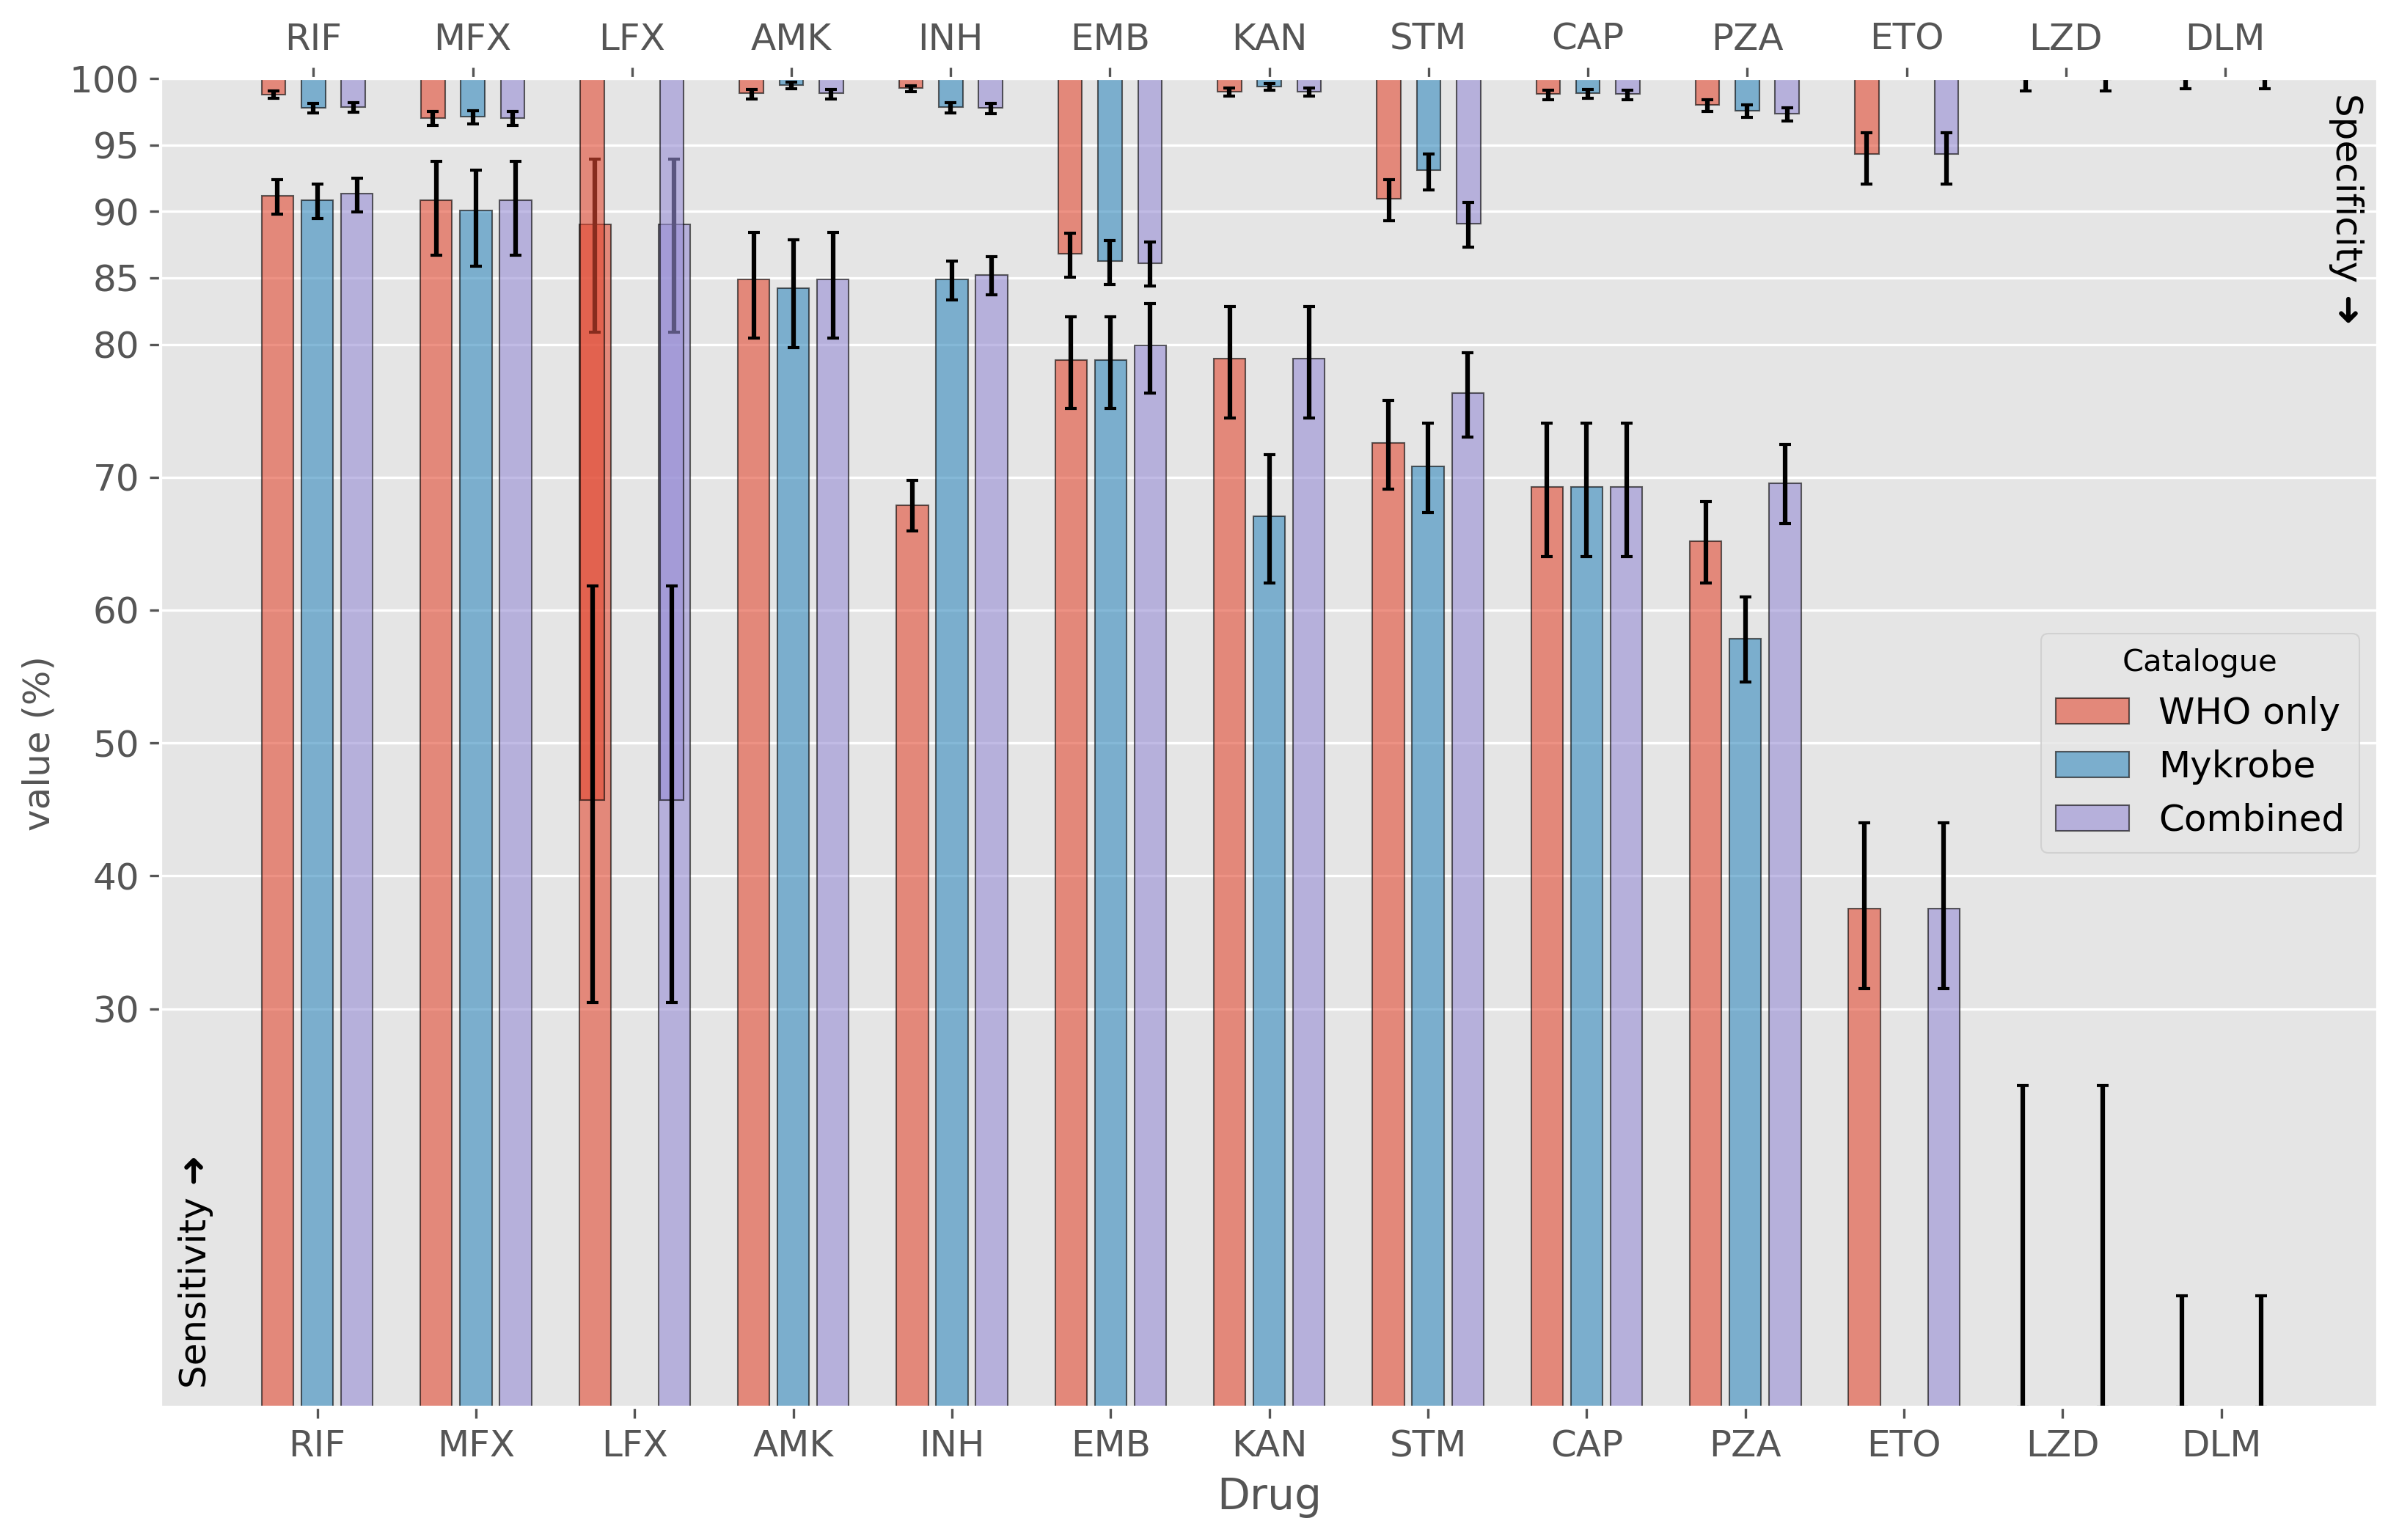

In [25]:
fig, axR = plt.subplots()
axS = axR.twiny()
ggplot_cm = plt.rcParams["axes.prop_cycle"].by_key()["color"]
red = ggplot_cm[0]
blue = ggplot_cm[1]
purple = ggplot_cm[2]
black = ggplot_cm[3]
edgecol = "black"
cmap = [red, blue, purple]
# plot details
bar_width = 0.2
epsilon = 0.05
line_width = 0.5
fs = 12
rotate = 0
capsize = 2
alpha = 1.0
bar_alpha = 0.6
hatch = ""

all_positions = []
for i, panel in enumerate(["who2021", "hunt2019", "hall2022"]):
    ix = (d, panel)
    panel_sn_df = sn_df.query("panel==@panel")
    sn_ys = panel_sn_df["value"] * 100
    sn_lb = sn_ys - panel_sn_df["lower"] * 100
    sn_ub = panel_sn_df["upper"] * 100 - sn_ys
    
    positions = [p + ((bar_width + epsilon) * i) for p in np.arange(len(sn_ys))]
    all_positions.append(positions)
    
    colour = cmap[i]

    # resistance bar plots
    sn_bar = axR.bar(
        positions,
        sn_ys,
        bar_width,
        yerr=[sn_lb, sn_ub],
        color=colour,
        edgecolor=edgecol,
        linewidth=line_width,
        capsize=capsize,
        alpha=bar_alpha
    )

    panel_sp_df = sp_df.query("panel==@panel")
    sp_ys = panel_sp_df["value"] * 100
    sp_lb = sp_ys - panel_sp_df["lower"] * 100
    sp_ub = panel_sp_df["upper"] * 100 - sp_ys
    sp_ub = [min(100, x) for x in sp_ub]
    
    sp_bar = axS.bar(
        positions,
        height=-(100-sp_ys),
        bottom=100,
        width=bar_width*0.75,
        yerr=[sp_lb, sp_ub],
        alpha=bar_alpha,
        color=colour,
        edgecolor=edgecol,
        linewidth=line_width,
        capsize=capsize,
        error_kw=dict(barsabove=True)
    )
    sn_bar.set_label(panel_names[panel.lower()])


labels = [abbrev[d] for d in ordered_drugs]
label_pos = [np.mean(ps) for ps in zip(*all_positions)]
plt.xticks(label_pos, labels, rotation=rotate, fontsize=fs)
axR.set_ylabel("value (%)")
yticks = [30, 40, 50, 60, 70, 80, 85, 90, 95, 100]
axR.set_yticks(yticks)
axR.set_yticklabels(yticks)
axR.set_xticks(label_pos)
axR.set_xticklabels(axS.get_xticklabels(), rotation=rotate, fontsize=fs)
axR.tick_params("both", labelsize=fs)
# axR.set_title("Specificity")
# axS.set_title("Susceptible")
plt.text(-0.6, 2,
    "Sensitivity ➜", 
    rotation="vertical", 
    fontsize=fs,
)
plt.text(12.9, 82,
    "Specificity ➜", 
    rotation=270, 
    fontsize=fs,
)

leghandles, leglabels = axR.get_legend_handles_labels()
axR.legend(leghandles, leglabels, loc="center right", prop={"size": fs}, title="Catalogue")
axS.grid(False)
axR.grid(False, axis="x",)
axR.set_xlabel("Drug", fontsize=fs+2)

In [26]:
print(table.to_markdown(index=False).replace(".", "·"))

| Drug         | Catalogue   | FN(R)     | FP(S)     | Sensitivity (95% CI)   | Specificity (95% CI)   |
|:-------------|:------------|:----------|:----------|:-----------------------|:-----------------------|
| Amikacin     | Combined    | 47(311)   | 38(3436)  | 84·9% (80·5-88·4%)     | 98·9% (98·5-99·2%)     |
| Amikacin     | Mykrobe     | 49(311)   | 16(3436)  | 84·2% (79·8-87·9%)     | 99·5% (99·2-99·7%)     |
| Amikacin     | WHO only    | 47(311)   | 38(3436)  | 84·9% (80·5-88·4%)     | 98·9% (98·5-99·2%)     |
| Capreomycin  | Combined    | 98(319)   | 42(3603)  | 69·3% (64·0-74·1%)     | 98·8% (98·4-99·1%)     |
| Capreomycin  | Mykrobe     | 98(319)   | 39(3603)  | 69·3% (64·0-74·1%)     | 98·9% (98·5-99·2%)     |
| Capreomycin  | WHO only    | 98(319)   | 42(3603)  | 69·3% (64·0-74·1%)     | 98·8% (98·4-99·1%)     |
| Delamanid    | Combined    | 42(42)    | 0(492)    | 0·0% (0·0-8·4%)        | 100·0% (99·2-100·0%)   |
| Delamanid    | Mykrobe     | 0(0)      | 0(0)      | 